# Capstone Project - The Battle of Neighborhoods in Milan

## Part 1 - Obtaining Milan's Boroughs Data

In [1]:
import numpy as np 
import pandas as pd 

!conda install -c conda-forge lxml --yes

Solving environment: ...working... done

# All requested packages already installed.



#### Let's start by downloading the information on the municipalities of Milan from the corresponding Wikipedia page, and cleaning/formatting them 

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/Municipalities_of_Milan')[1]
df.dropna(inplace=True)
df['Borough'] = df['Borough'].astype(str)
df['Borough'].replace('\.0','',regex=True, inplace = True)
df['Borough'] = "Zona "+df['Borough']+" of Milan"
df.drop("Quartieri (districts)",axis=1,inplace=True)
df.rename(columns={"Name" : "Districts", "Area(km2)" : "Area","Population(2014)" : "Population", "Population density(inhabitants/km2)" : "Density"},inplace=True)

df

,Borough,Districts,Area,Population,Density
0,Zona 1 of Milan,Centro storico,9.67,96315.000,11074
1,Zona 2 of Milan,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",12.58,153.109,13031
2,Zona 3 of Milan,"Città Studi, Lambrate, Porta Venezia",14.23,141229.000,10785
3,Zona 4 of Milan,"Porta Vittoria, Forlanini",20.95,156.369,8069
4,Zona 5 of Milan,"Vigentino, Chiaravalle, Gratosoglio",29.87,123779.000,4487
5,Zona 6 of Milan,"Barona, Lorenteggio",18.28,149000.000,8998
6,Zona 7 of Milan,"Baggio, De Angeli, San Siro",31.34,170814.000,6093
7,Zona 8 of Milan,"Fiera, Gallaratese, Quarto Oggiaro",23.72,181669.000,8326
8,Zona 9 of Milan,"Porta Garibaldi, Niguarda",21.12,181598.000,9204


In [3]:
df2 = df.drop(columns={"Area","Population","Density"})
df2 = pd.DataFrame(df2.Districts.str.split(',').tolist(), index=df.Borough).stack()
df2 = df2.reset_index([0, 'Borough'])
df2.columns = ['Borough', 'District']
df2["District"] = df2["District"].str.strip()

df2

,Borough,District
0,Zona 1 of Milan,Centro storico
1,Zona 2 of Milan,Stazione Centrale
2,Zona 2 of Milan,Gorla
3,Zona 2 of Milan,Turro
4,Zona 2 of Milan,Greco
5,Zona 2 of Milan,Crescenzago
6,Zona 3 of Milan,Città Studi
7,Zona 3 of Milan,Lambrate
8,Zona 3 of Milan,Porta Venezia
9,Zona 4 of Milan,Porta Vittoria


## Part 2 - Adding Geospatial Data

#### Let's download the required packadges and libraries

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="Milan_explorer")

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### Let's add latitude and longitude to our Borough data

In [5]:
df['Borough_Coord']= df['Borough'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Borough_Coord'].apply(pd.Series)

df.drop(['Borough_Coord'], axis=1, inplace=True)
df

,Borough,Districts,Area,Population,Density,Latitude,Longitude
0,Zona 1 of Milan,Centro storico,9.67,96315.000,11074,45.467281,9.185962
1,Zona 2 of Milan,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",12.58,153.109,13031,45.499990,9.218999
2,Zona 3 of Milan,"Città Studi, Lambrate, Porta Venezia",14.23,141229.000,10785,45.489800,9.241031
3,Zona 4 of Milan,"Porta Vittoria, Forlanini",20.95,156.369,8069,45.446205,9.239343
4,Zona 5 of Milan,"Vigentino, Chiaravalle, Gratosoglio",29.87,123779.000,4487,45.419846,9.198153
5,Zona 6 of Milan,"Barona, Lorenteggio",18.28,149000.000,8998,45.437929,9.145648
6,Zona 7 of Milan,"Baggio, De Angeli, San Siro",31.34,170814.000,6093,45.469598,9.114757
7,Zona 8 of Milan,"Fiera, Gallaratese, Quarto Oggiaro",23.72,181669.000,8326,45.500015,9.122774
8,Zona 9 of Milan,"Porta Garibaldi, Niguarda",21.12,181598.000,9204,45.507704,9.179410


#### Let's add latitude and longitude to our Districts data

In [6]:
df2['District2'] = df2['District']+", Milano, Italy"
df2['District_Coord']= df2['District2'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df2[['Latitude', 'Longitude']] = df2['District_Coord'].apply(pd.Series)
df2.drop(['District_Coord'], axis=1, inplace=True)
df2.drop(['District2'], axis=1, inplace=True)
df2

,Borough,District,Latitude,Longitude
0,Zona 1 of Milan,Centro storico,45.444613,9.096351
1,Zona 2 of Milan,Stazione Centrale,45.486659,9.207257
2,Zona 2 of Milan,Gorla,45.504945,9.224539
3,Zona 2 of Milan,Turro,45.497513,9.225896
4,Zona 2 of Milan,Greco,45.502184,9.211233
5,Zona 2 of Milan,Crescenzago,45.509219,9.247484
6,Zona 3 of Milan,Città Studi,45.477056,9.226575
7,Zona 3 of Milan,Lambrate,45.483148,9.241998
8,Zona 3 of Milan,Porta Venezia,45.474498,9.204801
9,Zona 4 of Milan,Porta Vittoria,45.462261,9.209580


#### Let's get the geographical coordinates of Milan

In [7]:
address = 'Milan'
geolocator = Nominatim(user_agent="Milan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milan are 45.4668, 9.1905.


#### Let's visualize the Boroughs and Districts Data

In [8]:
# create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers for Districts to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan) 

# add markers for Boroughs to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)
    
map_milan

# Part 3 - Downloading Restaurants Data

#### Next, we are going to use the Foursquare API to explore the boroughs and their restaurants

In [9]:
# @hidden_cell
CLIENT_ID = 'IQUV505J5GJ0A4NHRPGH1RU4M2S15QIQNXOSX0TSUPGKNEXS' # your Foursquare ID
CLIENT_SECRET = 'UNT24BKSP1W4WJW412CUVAZ0D2ITVZ2WKKJHCAENRZUHOPH1' # your Foursquare Secret
VERSION = '20200430'
LIMIT = 10000

#### The following function will be used to save venues' data from Foursquare

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

#### Here we apply the above function to districts together with their latitude and longitude

In [11]:
Milan_venues = getNearbyVenues(names=df2['District'], latitudes=df2['Latitude'], longitudes=df2['Longitude'], radius=5000)

Centro storico
Stazione Centrale
Gorla
Turro
Greco
Crescenzago
Città Studi
Lambrate
Porta Venezia
Porta Vittoria
Forlanini
Vigentino
Chiaravalle
Gratosoglio
Barona
Lorenteggio
Baggio
De Angeli
San Siro
Fiera
Gallaratese
Quarto Oggiaro
Porta Garibaldi
Niguarda


#### Here we see the count of restaurants depending on their category

In [31]:
# Create a dataframe out of it to consider only Restaurants 
Milan_restaurants = Milan_venues[Milan_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Milan_restaurants.index = np.arange(1, len(Milan_restaurants)+1)
print(Milan_restaurants['Venue Category'].value_counts())
#print(Milan_restaurants)

Italian Restaurant               230
Japanese Restaurant               64
Seafood Restaurant                61
Restaurant                        37
Sushi Restaurant                  35
Argentinian Restaurant            15
Sardinian Restaurant               7
Fast Food Restaurant               5
Tuscan Restaurant                  5
Roman Restaurant                   5
Middle Eastern Restaurant          4
Kebab Restaurant                   4
Chinese Restaurant                 4
Abruzzo Restaurant                 4
Scandinavian Restaurant            3
Lombard Restaurant                 2
Moroccan Restaurant                2
Caribbean Restaurant               2
Vegetarian / Vegan Restaurant      2
Mediterranean Restaurant           2
Vietnamese Restaurant              1
Cantonese Restaurant               1
French Restaurant                  1
Australian Restaurant              1
Ramen Restaurant                   1
Greek Restaurant                   1
Name: Venue Category, dtype: int64


## Part 4 - Analysing and Clustering Data

#### Let's examine the Top 5 categories of restaurants in Milan

In [13]:
Milan_10 = Milan_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='Frequency')
Milan_10.reset_index(inplace=True)
Milan_10.rename(index=str, columns={"index": "Venue_Category"}, inplace=True)

Milan_10

,Venue_Category,Frequency
0,Italian Restaurant,230
1,Japanese Restaurant,64
2,Seafood Restaurant,61
3,Restaurant,37
4,Sushi Restaurant,35
5,Argentinian Restaurant,15
6,Sardinian Restaurant,7
7,Fast Food Restaurant,5
8,Tuscan Restaurant,5
9,Roman Restaurant,5


#### One can easily notice that, apart from italian restaurants, the second largest portion of restaurants in Milan are focused on Japanese food (both Japanese and Sushi restaurants)

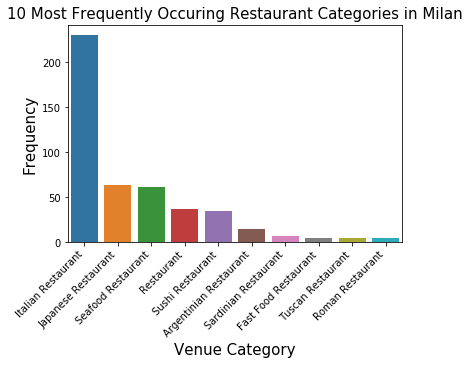

<Figure size 1296x504 with 0 Axes>

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Milan_10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Restaurant Categories in Milan', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [16]:
Restaurants_per_district = Milan_restaurants.groupby(['District'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Restaurants_per_district

District
Baggio               30
Barona               25
Centro storico       33
Chiaravalle          27
Città Studi          12
Crescenzago          21
De Angeli            22
Fiera                17
Forlanini            25
Gallaratese          22
Gorla                21
Gratosoglio          25
Greco                18
Lambrate             18
Lorenteggio          24
Niguarda             26
Porta Garibaldi      12
Porta Venezia        11
Porta Vittoria       15
Quarto Oggiaro       21
San Siro             24
Stazione Centrale    14
Turro                15
Vigentino            21
Name: Venue Category, dtype: int64

#### We now want to cluster the districts based on the their most common types of restaurants, and in order to do this, we need to prepare the data as follows

In [35]:
df3=Milan_restaurants
df3=df3.drop("Venue",axis=1)
df3=df3.drop("Venue Latitude",axis=1)
df3=df3.drop("Venue Longitude",axis=1)

Milan_onehot = pd.get_dummies(df3,columns=['Venue Category'], prefix="", prefix_sep="")
Milan_onehot.head()

,District,Abruzzo Restaurant,Argentinian Restaurant,Australian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lombard Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Ramen Restaurant,Restaurant,Roman Restaurant,Sardinian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Centro storico,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro storico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Centro storico,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro storico,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Centro storico,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
Restaurant_types_per_district=Milan_onehot.groupby('District').mean().reset_index()
Restaurant_types_per_district

,District,Abruzzo Restaurant,Argentinian Restaurant,Australian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lombard Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Ramen Restaurant,Restaurant,Roman Restaurant,Sardinian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Baggio,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.500000,0.100000,0.000000,0.00,0.033333,0.000000,0.000000,0.000000,0.100000,0.000000,0.033333,0.033333,0.100000,0.066667,0.000000,0.000000,0.000000
1,Barona,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,0.120000,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.040000,0.000000,0.200000,0.080000,0.040000,0.000000,0.000000
2,Centro storico,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.030303,0.000000,0.393939,0.151515,0.000000,0.00,0.030303,0.000000,0.000000,0.000000,0.121212,0.000000,0.030303,0.030303,0.090909,0.060606,0.000000,0.000000,0.000000
3,Chiaravalle,0.037037,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.444444,0.074074,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.185185,0.000000,0.000000,0.037037,0.074074,0.037037,0.000000,0.000000,0.000000
4,Città Studi,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000
5,Crescenzago,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.000000,0.523810,0.142857,0.000000,0.00,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000
6,De Angeli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.090909,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.272727,0.136364,0.045455,0.000000,0.000000
7,Fiera,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.294118,0.117647,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.176471,0.235294,0.000000,0.058824,0.000000
8,Forlanini,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,0.040000,0.000000,0.00,0.000000,0.080000,0.040000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000
9,Gallaratese,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.590909,0.136364,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.045455,0.000000,0.045455,0.090909,0.000000,0.000000,0.000000


#### Here we introduce a function that will extract the 5 most common restaurants for each district

In [38]:
def most_common_venues(row, n):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:n]

#### Finally we are able to construct the required dataframe

In [41]:
n = 10
indicators = ['st', 'nd', 'rd']

columns = ['District']
for ind in np.arange(n):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

district_top_5 = pd.DataFrame(columns=columns)
district_top_5['District'] = Restaurant_types_per_district['District']

for ind in np.arange(Restaurant_types_per_district.shape[0]):
    district_top_5.iloc[ind, 1:] = most_common_venues(Restaurant_types_per_district.iloc[ind, :], n)

district_top_5

,District,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Baggio,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Restaurant,Sushi Restaurant,Scandinavian Restaurant,Sardinian Restaurant,Chinese Restaurant,Mediterranean Restaurant,Australian Restaurant
1,Barona,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Sushi Restaurant,Lombard Restaurant,Restaurant,Argentinian Restaurant,Abruzzo Restaurant,Roman Restaurant,Tuscan Restaurant
2,Centro storico,Italian Restaurant,Japanese Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Scandinavian Restaurant,Sardinian Restaurant,Mediterranean Restaurant,French Restaurant
3,Chiaravalle,Italian Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Abruzzo Restaurant,Argentinian Restaurant,Sushi Restaurant,Scandinavian Restaurant,Chinese Restaurant,Fast Food Restaurant
4,Città Studi,Italian Restaurant,Japanese Restaurant,Restaurant,Argentinian Restaurant,Sushi Restaurant,Seafood Restaurant,Vietnamese Restaurant,Australian Restaurant,Cantonese Restaurant,Caribbean Restaurant
5,Crescenzago,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Sushi Restaurant,Seafood Restaurant,Cantonese Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Argentinian Restaurant
6,De Angeli,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Japanese Restaurant,Tuscan Restaurant,Sardinian Restaurant,Roman Restaurant,Vietnamese Restaurant,Argentinian Restaurant,Australian Restaurant
7,Fiera,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Argentinian Restaurant,Australian Restaurant,Cantonese Restaurant
8,Forlanini,Italian Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Moroccan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Argentinian Restaurant,Australian Restaurant,Cantonese Restaurant
9,Gallaratese,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Seafood Restaurant,Sardinian Restaurant,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Argentinian Restaurant,Australian Restaurant
